# Word frequency analysis
This notebook conducts word frequency analysis - it tries to identify what words are commonly used by politicians.

Let's first load the data:

In [2]:
import pandas as pd
# load the data
df = pd.read_pickle("../data/binary/us-politicians.pickle")
df.sample(5)

,speaker_id,quote_id,quotation,speaker,party
1598704,7287916,2017-07-06-045562,"I think if you want actual change, you should ...",Ralph Northam,29552
1546826,319079,2018-01-17-024107,Every two hours I woke up and cried.,Bob Dole,29468
186259,22686,2015-08-26-004711,"All I want is what's good for the country,",Donald Trump,29468
1327644,69319,2015-12-04-070164,"My mother told me one time, she said, `Johnny....",John Kasich,29468
47553,76,2015-12-11-025043,foresee a situation in which we can end the ci...,Barack Obama,29552


### Preprocessing the quotes
Now, let's define some utility functions that will allow us to apply preprocessing operations such as:
- changing string to lowercase
- removing numbers
- removing punctuation
- removing single characters
- removing leading, trailing and repeating spaces
- expanding contractions
- removing stopwords

In [3]:
import re, string, contractions
from nltk.tokenize import word_tokenize

def preprocess_quote(quote):
    # to lowercase
    quote = quote.lower()

    # remove numbers and punctuation
    quote = re.sub(r'\d+', '', quote)
    quote = quote.translate(str.maketrans('', '', string.punctuation))

    # remove all single characters
    quote = re.sub(r'\s+[a-zA-Z]\s+', ' ', quote)
    # Remove single characters from the start
    quote = re.sub(r'\^[a-zA-Z]\s+', ' ', quote)

    # remove leading, trailing, and repeating spaces
    quote = re.sub(' +', ' ', quote)
    quote = quote.strip()

    return quote
    
def expand_contractions(quote):
    return contractions.fix(quote)

def remove_words(quote, words):
    tokens = word_tokenize(quote)
    filtered_tokens = [token for token in tokens if token.lower() not in words]
    return " ".join(filtered_tokens)

And now let's apply the preprocessing functions to the data:

In [4]:
# take a sample of the dataset, extract the quotation strings
sample = df.sample(10000)
sample_quotes = sample["quotation"]
sample_quotes.head(5)

742293    What I do know is that even he said that the t...
818330    Richard Trumka has her mortified. She won't do...
166067    He never let us get out of line. He made us wo...
21619     Here in the United States, I expect robust deb...
679160    We are fine with that as long as the previousl...
Name: quotation, dtype: object

In [5]:
# expand contractions
sample_quotes = sample_quotes.apply(lambda quote: expand_contractions(quote))

# load the stopwords (extend the standard list by the contraction leftovers) and remove them from the quotes 
from nltk.corpus import stopwords
stopwords = stopwords.words('english') + ['nt', 'ca', 'wo']
print("Example stopwords: ", stopwords[:10])
sample_quotes = sample_quotes.apply(lambda quote: remove_words(quote, stopwords))

# apply other preprocessing
sample_quotes = sample_quotes.apply(lambda quote: preprocess_quote(quote))

Example stopwords:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [6]:
# look at most common words
tokenized = sample_quotes.apply(lambda quote: word_tokenize(quote))
words = tokenized.explode()
words = words.astype("str")
words.value_counts()

people          1133
going            864
would            773
think            714
president        609
                ... 
vegetables         1
warner             1
fooled             1
cryin              1
pathetically       1
Name: quotation, Length: 13134, dtype: int64

## Removing the most common words
As you can see above, the most common words are somewhat meaningless for understanding the topics that politicians talk about. They are just words that appear commonly in English language. To be able to draw conclusions from the frequency analysis, we remove the 1000 most common words from the quotations and repeat the analysis.

In [7]:
# load the list of most common english words, taken from: https://gist.github.com/deekayen/4148741
def read_most_common(path):
    most_common = []
    with open(path, "r") as file:
        for line in file.readlines():
            most_common.append(line.strip())
    return most_common

most_common = read_most_common("../data/misc/most_common_words_1000.txt")
most_common[:10]

['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that']

We make use of stemming to perform better filtering of the words. We first apply stemming to the list of common words, and then for each token in the quotations we check if the stemmed version of the token appears in the common words list. If it does, we discard this token.

In [9]:
# convert words to their stemmed versions
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
most_common_stemmed = [stemmer.stem(word) for word in most_common]
stemmed_words = {x: stemmer.stem(x) for x in (words.unique())}

# and filter out the words w
filtered_words = [word for word in words if stemmed_words[word] not in most_common_stemmed]

Now, let's look at the most common words again:

In [10]:
pd.Series(filtered_words).value_counts()[:10]

president    609
trump        427
american     314
america      291
really       284
something    233
security     178
today        168
americans    157
public       154
dtype: int64

The results are much more meaningful - we can see keywords like *'america', 'president' or 'administration'. Let's get a better understanding of it by plotting a word cloud:

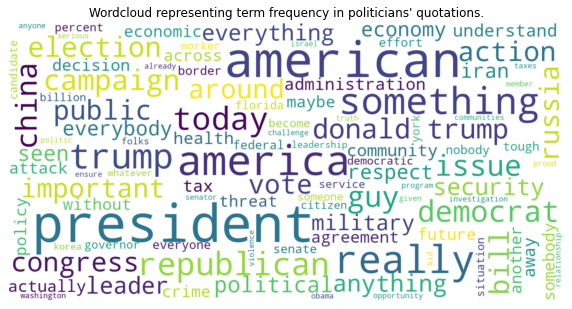

In [11]:
# adapted from: https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

wordcloud = WordCloud(width=1600, height = 800, max_font_size=150, max_words=100, background_color="white")
wordcloud.generate(" ".join(filtered_words))

plt.axis("off")
plt.title("Wordcloud representing term frequency in politicians' quotations.")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()